# Time series of editing

In [ ]:
# Import libs
import pandas as pd
import numpy as np
import re
import csv
from tqdm import tqdm
from collections import Counter
import matplotlib.dates as mdates
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
tqdm.pandas()

# Set width
pd.set_option('display.max_colwidth', 50)

# Set random seed
np.random.seed(42)  # or any consistent seed value

# Configuration
LOWESS_FRAC = 0.1  # LOWESS smoothing fraction

## Set-up & Pre-processing

In [ ]:
# Load df
df_raw = pd.read_csv('data/df_wikimedia_full_dataset.csv')
df_raw.head(3)

,revid,prediction,prob_true,prob_false,user,timestamp,comment,page_title,parentid,affiliation,pol_type,category
0,1131745377,False,0.290185,0.709815,Upton Liptrot,2023-01-05 15:17:36+00:00,/* External links */,Ed Case,1.130748e+09,Democrat,house,House
1,1215738747,False,0.234020,0.765980,Upton Liptrot,2024-03-26 20:57:24+00:00,/* External links */,Ed Case,1.214732e+09,Democrat,house,House
2,993040664,False,0.096793,0.903207,Pvmoutside,2020-12-08 13:55:13+00:00,/* External links */,Ed Case,9.891951e+08,Democrat,house,House


In [16]:
# Dataset overview
print(f"Total unique pages: {len(df_raw.page_title.unique())}")
print(f"Total edits: {len(df_raw)}")

# Convert timestamp to datetime for date range calculation
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
print(f"Date range: {df_raw.timestamp.min()} to {df_raw.timestamp.max()}")

Total unique pages: 536
Total edits: 159053
Date range: 2020-11-03 01:25:11+00:00 to 2024-07-26 21:42:49+00:00


In [17]:
# Filter by political type and affiliation
df_house = df_raw[df_raw['pol_type'] == 'house'].copy()
df_senate = df_raw[df_raw['pol_type'] == 'senate'].copy()

# Get unique politicians by affiliation
df_house_unique = df_house.drop_duplicates(subset='page_title')
df_senate_unique = df_senate.drop_duplicates(subset='page_title')

print("House affiliation distribution:")
print(df_house_unique.affiliation.value_counts())
print("\nSenate affiliation distribution:")
print(df_senate_unique.affiliation.value_counts())


House affiliation distribution:
affiliation
Democrat      221
Republican    210
Name: count, dtype: int64

Senate affiliation distribution:
affiliation
Republican     49
Democrat       47
Independent     4
Name: count, dtype: int64


In [18]:
# Add edit counter variable
df_raw['posted'] = 1

# Create subsets by affiliation
df_reps = df_raw[df_raw['affiliation'] == 'Republican'][['timestamp', 'posted']].copy()
df_dems = df_raw[df_raw['affiliation'] == 'Democrat'][['timestamp', 'posted']].copy()
df_inds = df_raw[df_raw['affiliation'] == 'Independent'][['timestamp', 'posted']].copy()

# Create subsets by candidate
df_trump = df_raw[df_raw['page_title'] == 'Donald Trump'][['timestamp', 'posted']].copy()
df_biden = df_raw[df_raw['page_title'] == 'Joe Biden'][['timestamp', 'posted']].copy()
df_harris = df_raw[df_raw['page_title'] == 'Kamala Harris'][['timestamp', 'posted']].copy()

print(f"Republicans: {len(df_reps)}, Democrats: {len(df_dems)}, Independents: {len(df_inds)}")
print(f"Trump: {len(df_trump)}, Biden: {len(df_biden)}, Harris: {len(df_harris)}")


Republicans: 84469, Democrats: 69678, Independents: 3214
Trump: 9985, Biden: 4797, Harris: 1613


In [ ]:
# Preprocess df
def process_dataframe(df, new_col_name):
    """Convert timestamp to datetime index, aggregate numeric columns by day, and rename 'posted' column."""
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    numeric_columns = df.select_dtypes(include=['number']).columns
    df = df[numeric_columns].groupby(pd.Grouper(freq='D')).sum()
    df = df.reset_index()
    df = df.rename(columns={'posted': new_col_name})
    return df


# Process all dataframes
df_reps = process_dataframe(df_reps, 'reps_posted')
df_dems = process_dataframe(df_dems, 'dems_posted')
df_inds = process_dataframe(df_inds, 'inds_posted')
df_trump = process_dataframe(df_trump, 'trump_posted')
df_harris = process_dataframe(df_harris, 'harris_posted')
df_biden = process_dataframe(df_biden, 'biden_posted')

In [20]:
# new merging
df_merged1 = pd.merge(df_reps, df_dems, on='timestamp', how='inner')
df_merged2 = pd.merge(df_merged1, df_inds, on='timestamp', how='inner')
len(df_merged2)

1362

In [21]:
# new merging
df_candidates1 = pd.merge(df_trump, df_harris, on='timestamp', how='inner')
df_candidates = pd.merge(df_candidates1, df_biden, on='timestamp', how='inner')
len(df_candidates)

1362

## Check highest N of edits

In [ ]:
# Identify peak editing days by party affiliation
print("=== Top editing days by party ===")
print("\nRepublicans (top 10):")
print(df_merged2.nlargest(10, 'reps_posted')[['timestamp', 'reps_posted', 'dems_posted', 'inds_posted']])

print("\nDemocrats (top 10):")
print(df_merged2.nlargest(10, 'dems_posted')[['timestamp', 'reps_posted', 'dems_posted', 'inds_posted']])

print("\nIndependents (top 10):")
print(df_merged2.nlargest(10, 'inds_posted')[['timestamp', 'reps_posted', 'dems_posted', 'inds_posted']])

=== Top editing days by party ===

Republicans (top 10):
                     timestamp  reps_posted  dems_posted  inds_posted
1086 2023-10-25 00:00:00+00:00          729           74            3
65   2021-01-07 00:00:00+00:00          603          306           13
793  2023-01-05 00:00:00+00:00          514          414            4
1351 2024-07-16 00:00:00+00:00          479           70            0
791  2023-01-03 00:00:00+00:00          446          523           13
71   2021-01-13 00:00:00+00:00          445          228            4
61   2021-01-03 00:00:00+00:00          395          277            6
66   2021-01-08 00:00:00+00:00          393          257           12
62   2021-01-04 00:00:00+00:00          365          231            5
1087 2023-10-26 00:00:00+00:00          349           93            1

Democrats (top 10):
                    timestamp  reps_posted  dems_posted  inds_posted
78  2021-01-20 00:00:00+00:00          315          536            4
791 2023-01-03

## Plotting

In [ ]:
# Prepare data for plotting
def process_df(df):
    """Convert timestamp to datetime index, fill missing values, and aggregate numeric columns by day."""
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    df = df.ffill().bfill()
    numeric_columns = df.select_dtypes(include=['number']).columns
    return df[numeric_columns].groupby(pd.Grouper(freq='D')).sum()


# Process dataframes
df_merged2 = process_df(df_merged2)
df_candidates = process_df(df_candidates)

In [24]:
# Key dates for annotations
events = {
    '2020-11-07': 'Biden wins the 2020 presidential election',
    '2021-01-06': 'Capitol attack & 2nd Trump impeachment',
    '2021-01-20': 'Biden inaugurates as 46th president',
    '2021-02-02': 'Harris speaks with Trudeau in first foreign leader call',
    '2021-02-13': 'Trump acquitted by Senate & Biden announces orders on climate change',
    '2021-03-30': 'Biden signs the American Rescue Plan into law',
    '2021-04-26': '2020 census apportionment figures released',
    '2021-06-26': 'Trump begins campaign-style rallies',
    '2021-07-11': 'Biden delivers a speech about his first 6 months in office',
    '2021-08-01': 'Harris visits Vietnam',
    '2021-08-27': 'Biden addresses Afghanistan evacuation amid Taliban takeover',
    '2021-10-03': 'Trump holds a rally in Iowa & House Select Committee investigates Capitol attack',
    '2022-01-03': 'January 6 committee reports are made public',
    '2022-01-19': 'Biden announces Strategy Against Covid & Harris as running mate in 2024',
    '2022-02-27': 'Trump wins the 2022 CPAC straw poll',
    '2022-03-15': 'Trump holds a rally in SC & Biden signs the Consolidated Appropriations Act',
    '2022-05-02': 'Leaked draft opinion on overturning Roe v. Wade',
    '2022-06-06': 'Supreme Court ruled on voting rights and election laws',
    '2022-06-24': 'Supreme Court overturns Roe v. Wade',
    '2022-09-14': "Senate votes on climate change & Harris speaks on women's rights",
    '2022-11-08': '2022 Midterm elections',
    '2022-11-20': 'Trump announces 2024 presidential candidacy',
    '2023-01-03': 'Kevin McCarthy elected new House Speaker',
    '2023-02-14': 'Haley announces bid for Republican nomination',
    '2023-04-25': 'Biden announces re-election bid',
    '2023-05-24': 'DeSantis, Pence & Burgum to run for president',
    '2023-06-13': 'Trump pleads not guilty to 37 felony counts & West to run for president',
    '2023-07-08': 'Iowa Republican Party sets caucus date for January 15, 2024',
    '2023-08-23': 'First Republican primary debate & Biden visited a community centre in Arizona',
    '2023-10-29': "Trump's rally in Nevada, Mike Johnson new House Speaker",
    '2024-01-15': 'Iowa Republican caucuses & New Hampshire primaries',
    '2024-02-03': 'S. Carolina & Nevada Democratic primary',
    '2024-02-24': 'Nevada, Virgin Islands, S. Carolina & Michigan Rep caucuses/primaries',
    '2024-03-05': 'Super Tuesday primaries',
    '2024-04-25': 'Biden announces re-election bid, Harris confirmed as running mate',
    '2024-05-23': 'Reform Party nominates Kennedy & Trump found guilty in NY trial',
    '2024-06-27': 'First Biden-Trump debate',
    '2024-07-13': "Trump's assassination attempt, RNC & Biden drops out",
}

## Parties

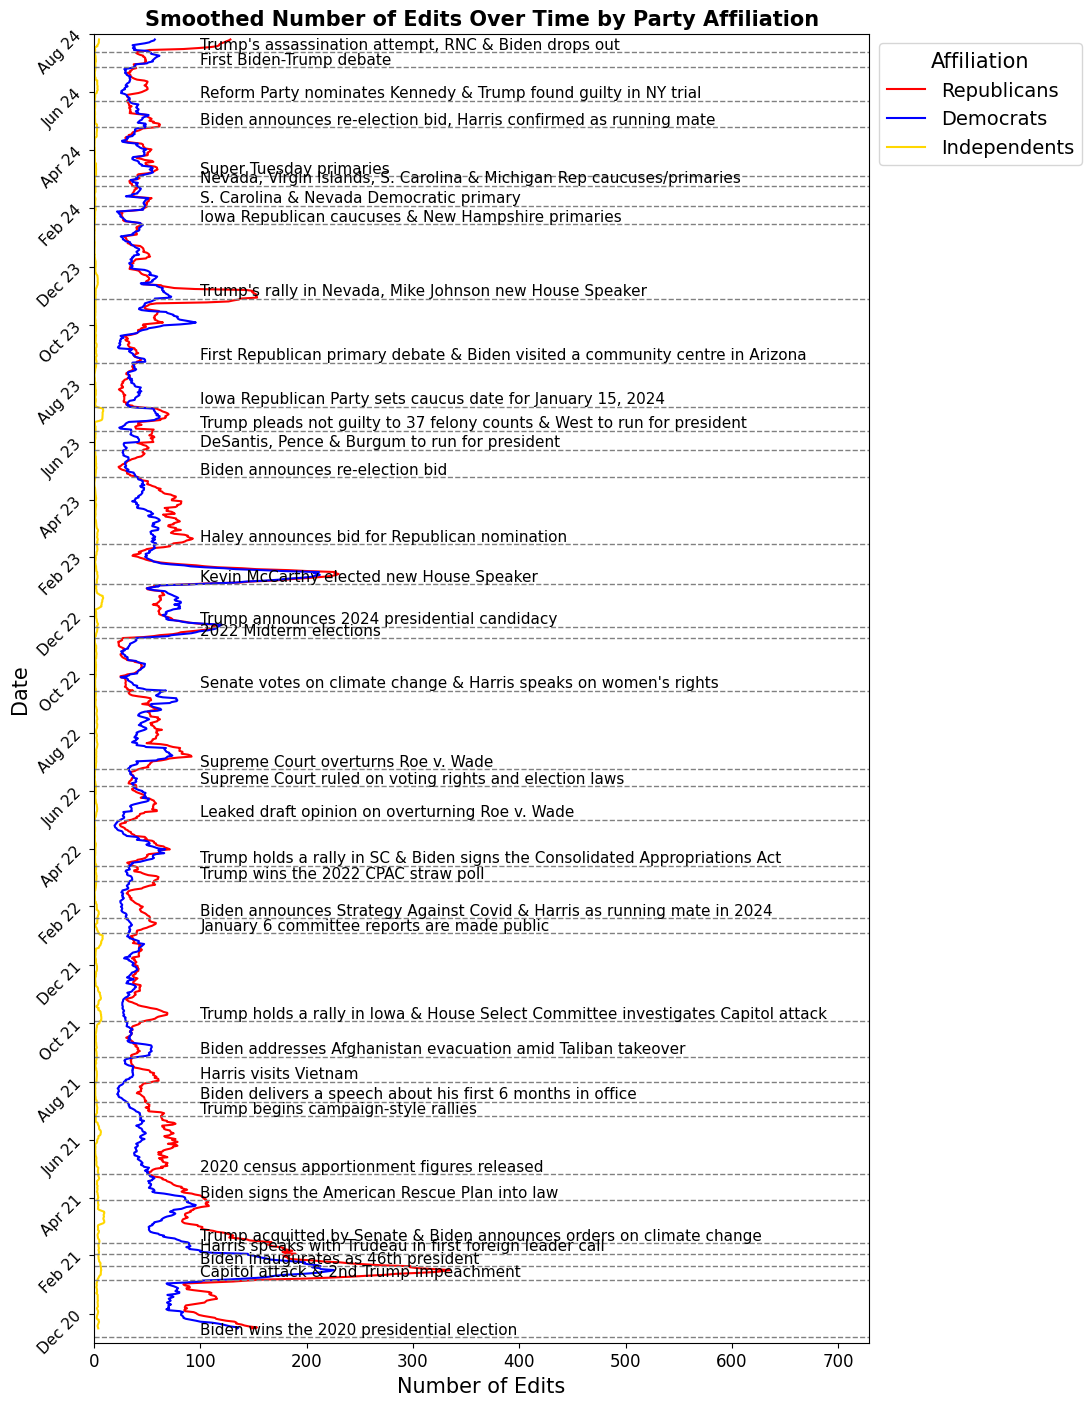

In [25]:
# Define columns
posted_columns = ['reps_posted', 'dems_posted', 'inds_posted']

# Define the corresponding colors for each column
colors = {
    'dems_posted': 'blue',
    'reps_posted': 'red',
    'inds_posted': 'gold'
}

# Define the labels for each column
labels = {
    'dems_posted': 'Democrats',
    'reps_posted': 'Republicans',
    'inds_posted': 'Independents',
}

# Plot the smoothed number of edits
plt.figure(figsize=(10, 17))  # Adjust figure size for vertical orientation

for posted_column in posted_columns:
    # Smooth the number of edits
    smoothed_positive = df_merged2[posted_column].rolling(window=14).mean()

    # Plot the smoothed number of edits with dates on the y-axis
    plt.plot(smoothed_positive, df_merged2.index, label=labels[posted_column], color=colors[posted_column])

# Add horizontal lines and annotations for key dates (previously vertical)
for date, event in events.items():
    plt.axhline(pd.to_datetime(date), color='gray', linestyle='--', linewidth=1)
    plt.text(100, pd.to_datetime(date), event, rotation=0, verticalalignment='bottom', fontsize=11)

# Configure y-axis for monthly ticks (dates)
plt.gca().yaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

# Set limits (inverted axes)
# Number of edits on x-axis, dates on y-axis
plt.xlim(df_merged2[posted_columns].min().min(), df_merged2[posted_columns].max().max())
plt.ylim(pd.to_datetime('2020-11'), pd.to_datetime('2024-08'))

plt.ylabel('Date', fontsize=15)  # Date label on y-axis
plt.xlabel('Number of Edits', fontsize=15)  # Edits label on x-axis
plt.title('Smoothed Number of Edits Over Time by Party Affiliation', fontsize=15, fontweight='bold')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Affiliation', fontsize=14, title_fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11, rotation=45)

# Save the plot in high resolution
plt.savefig("figures/time-series-editing-party-affiliation.png", dpi=400, bbox_inches='tight')

# Show plot
plt.show()


## Candidates

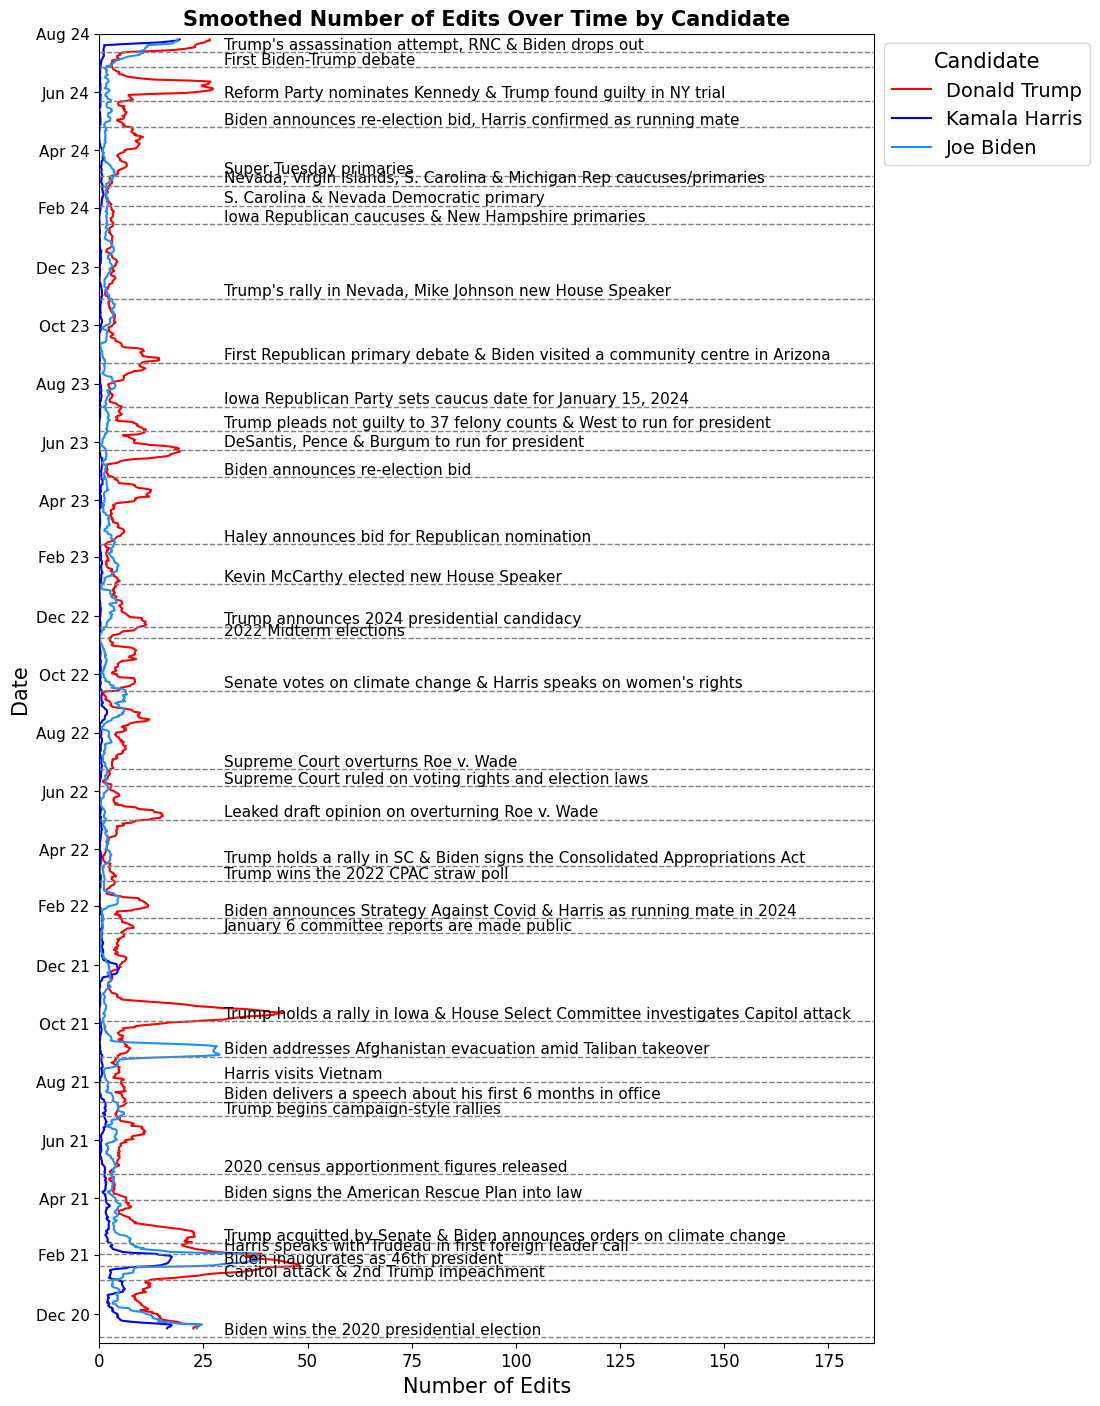

In [26]:
# Define columns
posted_columns = ['trump_posted', 'harris_posted', 'biden_posted']

# Define the corresponding colors for each column
colors = {
    'harris_posted': 'blue',
    'biden_posted': 'dodgerblue',
    'trump_posted': 'red',
}

# Define the labels for each column
labels = {
    'harris_posted': 'Kamala Harris',
    'biden_posted': 'Joe Biden',
    'trump_posted': 'Donald Trump',
}

# Plot the smoothed number of edits
plt.figure(figsize=(10, 17))  # Adjust figure size for vertical orientation

for posted_column in posted_columns:
    # Smooth the number of edits
    smoothed_positive = df_candidates[posted_column].rolling(window=14).mean()

    # Plot the smoothed number of edits with dates on the y-axis
    plt.plot(smoothed_positive, df_candidates.index, label=labels[posted_column], color=colors[posted_column])

# Add horizontal lines and annotations for key dates (previously vertical)
for date, event in events.items():
    plt.axhline(pd.to_datetime(date), color='gray', linestyle='--', linewidth=1)
    plt.text(30, pd.to_datetime(date), event, rotation=0, verticalalignment='bottom', fontsize=11)

# Configure y-axis for monthly ticks (dates)
plt.gca().yaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

# Set limits (inverted axes)
# Number of edits on x-axis, dates on y-axis
plt.xlim(df_candidates[posted_columns].min().min(), df_candidates[posted_columns].max().max())
plt.ylim(pd.to_datetime('2020-11'), pd.to_datetime('2024-08'))

plt.ylabel('Date', fontsize=15)  # Date label on y-axis
plt.xlabel('Number of Edits', fontsize=15)  # Edits label on x-axis
plt.title('Smoothed Number of Edits Over Time by Candidate', fontsize=15, fontweight='bold')
plt.legend(bbox_to_anchor=(1, 1), loc='best', title='Candidate', fontsize=14, title_fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)

# Save the plot in high resolution
plt.savefig("figures/time-series-editing-candidate.png", dpi=400, bbox_inches='tight')

# Show plot
plt.show()
